In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import json
from dotenv import load_dotenv

# API 암호화를 위해 dotenv를 활용 
load_dotenv()
huggingface_token = os.environ.get("HUGGINGFACE_TOKEN")
ckp_number = 150 

# 데이터 불러오기 

In [2]:
# 시스템 프롬프트 설정 
system_message = "당신은 이미지와 제품명(name)으로부터 패션/스타일 정보를 추론하는 분류 모델입니다."

# 실제로 사용자 입력 -> 모델이 답해야 하는 프롬프트
prompt = """입력 정보:
- name: {name}
- image: [image]

위 정보를 바탕으로, 아래 7가지 key에 대한 값을 JSON 형태로 추론해 주세요:
1) gender
2) masterCategory
3) subCategory
4) season
5) usage
6) baseColour
7) articleType

출력 시 **아래 JSON 예시 형태**를 반드시 지키세요:
{{
  "gender": "예시값",
  "masterCategory": "예시값",
  "subCategory": "예시값",
  "season": "예시값",
  "usage": "예시값",
  "baseColour": "예시값",
  "articleType": "예시값"
}}

# 예시
{{
  "gender": "Men",
  "masterCategory": "Accessories",
  "subCategory": "Eyewear",
  "season": "Winter",
  "usage": "Casual",
  "baseColour": "Blue",
  "articleType": "Sunglasses"
}}

# 주의
- 7개 항목 이외의 정보(텍스트, 문장 등)는 절대 포함하지 마세요.
"""

In [3]:
from datasets import load_dataset

# label을 생성하기 위한 함수 
def combine_cols_to_label(example):
    label_dict = {
        "gender": example["gender"],
        "masterCategory": example["masterCategory"],
        "subCategory": example["subCategory"],
        "season": example["season"],
        "usage": example["usage"],
        "baseColour": example["baseColour"],
        "articleType": example["articleType"],
    }
    example["label"] = json.dumps(label_dict, ensure_ascii=False)
    return example

# 대화용 포맷으로 변환하는 함수 
def format_data(sample):
    return {
        "messages": [
            {
                "role": "system",
                "content": [
                    {
                        "type": "text",
                        "text": system_message
                    }
                ],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        # 제품명 
                        "text": prompt.format(name=sample["productDisplayName"]),
                    },
                    {
                        "type": "image",
                        # 이미지 파일 
                        "image": sample["file_path"],  
                    }
                ],
            },
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        # combine_cols_to_label에서 만든 JSON 문자열
                        "text": sample["label"],
                    }
                ],
            },
        ],
    }

# 전처리한 데이터셋 불러오기 
dataset = load_dataset("daje/kaggle-image-datasets", split="train")
dataset_add_label = dataset.map(combine_cols_to_label)
dataset_add_label = dataset_add_label.shuffle(seed=4242)

In [4]:
# 라벨을 추가한 데이터의 예시 
dataset_add_label[0]

{'file_path': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=60x80>,
 'id': 44429,
 'gender': 'Men',
 'masterCategory': 'Footwear',
 'subCategory': 'Shoes',
 'articleType': 'Formal Shoes',
 'baseColour': 'Black',
 'season': 'Summer',
 'year': '2013',
 'usage': 'Formal',
 'productDisplayName': 'Gliders Men Black Formal Shoes',
 'label': '{"gender": "Men", "masterCategory": "Footwear", "subCategory": "Shoes", "season": "Summer", "usage": "Formal", "baseColour": "Black", "articleType": "Formal Shoes"}'}

In [5]:
# 메세지 포맷으로 데이터셋 변환 
formatted_dataset = [format_data(row) for row in dataset_add_label]

In [6]:
# 메세지 포맷으로 변환 데이터 예시 
formatted_dataset[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': '당신은 이미지와 제품명(name)으로부터 패션/스타일 정보를 추론하는 분류 모델입니다.'}]},
  {'role': 'user',
   'content': [{'type': 'text',
     'text': '입력 정보:\n- name: Gliders Men Black Formal Shoes\n- image: [image]\n\n위 정보를 바탕으로, 아래 7가지 key에 대한 값을 JSON 형태로 추론해 주세요:\n1) gender\n2) masterCategory\n3) subCategory\n4) season\n5) usage\n6) baseColour\n7) articleType\n\n출력 시 **아래 JSON 예시 형태**를 반드시 지키세요:\n{\n  "gender": "예시값",\n  "masterCategory": "예시값",\n  "subCategory": "예시값",\n  "season": "예시값",\n  "usage": "예시값",\n  "baseColour": "예시값",\n  "articleType": "예시값"\n}\n\n# 예시\n{\n  "gender": "Men",\n  "masterCategory": "Accessories",\n  "subCategory": "Eyewear",\n  "season": "Winter",\n  "usage": "Casual",\n  "baseColour": "Blue",\n  "articleType": "Sunglasses"\n}\n\n# 주의\n- 7개 항목 이외의 정보(텍스트, 문장 등)는 절대 포함하지 마세요.\n'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=60x80>}]},
  {'role': 'assistant',
   'con

In [7]:
from sklearn.model_selection import train_test_split

# test_size=0.1로 설정하여 전체 데이터의 10%를 테스트 세트로 분리
train_dataset, test_dataset = train_test_split(formatted_dataset, 
                                             test_size=0.1, 
                                             random_state=42)

In [8]:
# train_dataset, test_dataset 데이터 수 확인 
len(train_dataset), len(test_dataset)

(39996, 4444)

In [9]:
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from qwen_vl_utils import process_vision_info

#############################################
# "배치 추론"용 함수
#############################################
def generate_batch_description(batch_messages, model, processor):
    # 배치 전체의 text / images / videos를 한번에 준비
    texts = []
    all_image_inputs = []
    all_video_inputs = []

    # (A) 각 샘플마다 QWen-VL용 텍스트 생성 + 이미지/비디오 추출
    for messages in batch_messages:
        # 1) QWen-VL 텍스트 템플릿 생성
        text_prompt = processor.apply_chat_template(
            messages, 
            tokenize=False, 
            add_generation_prompt=True
        )
        texts.append(text_prompt)

        # 2) 이미지/비디오 추출
        image_inputs, video_inputs = process_vision_info(messages)

        # 비디오가 없는 경우가 대부분이면, video_inputs를 무조건 None으로 처리해도 됨.
        all_image_inputs.append(image_inputs[0] if image_inputs else None)
        all_video_inputs.append(video_inputs[0] if video_inputs else None)

    # (B) 비디오가 전혀 없으면 videos=None으로 넘기도록 처리
    if any(x is not None for x in all_video_inputs):
        videos_to_pass = all_video_inputs
    else:
        videos_to_pass = None  

    # (C) processor로 배치 전체 인코딩
    inputs = processor(
        text=texts,
        images=all_image_inputs if any(x is not None for x in all_image_inputs) else None,
        videos=videos_to_pass,
        return_tensors="pt",
        padding=True
    )
    inputs = inputs.to(model.device)

    # (D) 모델 추론
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            top_p=1.0,
            do_sample=True,
            temperature=0.1
        )

    # (E) 디코딩
    batch_outputs = []
    for i, out_ids in enumerate(generated_ids):
        prompt_len = len(inputs.input_ids[i])
        trimmed_out_ids = out_ids[prompt_len:]
        decoded = processor.decode(
            trimmed_out_ids,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=False
        )
        batch_outputs.append(decoded)

    return batch_outputs

# 모델 불러오기 

In [10]:
from transformers import AutoModelForVision2Seq, AutoProcessor

# 허깅페이스 모델 ID
model_id = "Qwen/Qwen2-VL-7B-Instruct" 

# 모델과 프로세서 불러오기 
model = AutoModelForVision2Seq.from_pretrained(
   model_id,
   # GPU 메모리에 자동 할당
   device_map="auto",                            
   # bfloat16 정밀도 사용
   torch_dtype=torch.bfloat16,                   
)

# 텍스트/이미지 전처리 프로세스 
processor = AutoProcessor.from_pretrained(model_id)  

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
# 학습한 로라 어댑터가 있는 경로
adapter_path = f"./kaggle_image_prediction_qkvupdg_1e-5_seperate/checkpoint-{ckp_number}"

# Adapter 로드
model.load_adapter(
    adapter_path,
    adapter_name="adapter") 

# 단일 인퍼런스

In [12]:
# 한 개만 이미지만 인퍼런스하는 함수 
def generate_description(messages, model, processor):
   text = processor.apply_chat_template(
       messages, tokenize=False, add_generation_prompt=True
   )
   image_inputs, video_inputs = process_vision_info(messages)
   inputs = processor(
       text=[text],
       images=image_inputs,
       videos=video_inputs,
       padding=True,
       return_tensors="pt",
   )
   inputs = inputs.to(model.device)
   
   generated_ids = model.generate(
      **inputs, 
      max_new_tokens=128,
      top_p=1.0, 
      do_sample=True, 
      temperature=0.1
      )
   generated_ids_trimmed = [
      out_ids[len(in_ids) :] 
      for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
   output_text = processor.batch_decode(
       generated_ids_trimmed, 
       skip_special_tokens=True, 
       clean_up_tokenization_spaces=False
   )
   return output_text[0]

In [13]:
# 1번 데이터만 예측하기 
idx = 1 
messages =  test_dataset[idx]["messages"][:2]
answer = test_dataset[idx]["messages"][2]["content"][0]["text"]
ft_description = generate_description(messages, model, processor)

In [14]:
# 예측결과, 정답, 일치여부
ft_description, answer, ft_description == answer

('{"gender": "Women", "masterCategory": "Apparel", "subCategory": "Innerwear", "season": "Summer", "usage": "Casual", "baseColour": "Blue", "articleType": "Nightdresses"}',
 '{"gender": "Women", "masterCategory": "Apparel", "subCategory": "Loungewear and Nightwear", "season": "Winter", "usage": "Casual", "baseColour": "Blue", "articleType": "Nightdress"}',
 False)

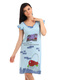

In [15]:
test_dataset[idx]["messages"][1]["content"][1]["image"]

# 배치 인퍼런스 

In [16]:
model.eval()
after_train_results = []
batch_size = 32

# 배치단위로 for문을 돌면서 generate_batch_description함수를 이용하여 인퍼런스를 진행합니다. 
for start_idx in tqdm(range(0, len(test_dataset), batch_size)):
    batch_data = test_dataset[start_idx : start_idx + batch_size]

    batch_messages = []
    answers = []  # 각 샘플 정답
    for item in batch_data:
        # system+user 메시지
        sys_usr = item["messages"][:2]
        batch_messages.append(sys_usr)

        # 정답(assistant)
        ans_text = item["messages"][2]["content"][0]["text"]
        answers.append(ans_text)

    # 한 번에 모델 추론
    predicted_texts = generate_batch_description(batch_messages, model, processor)

    # 결과 저장
    for ans, pred in zip(answers, predicted_texts):
        after_train_results.append((ans, pred))

  0%|          | 0/139 [00:00<?, ?it/s]

# 예측 결과 확인 

#### 4번 데이터 예측 

In [17]:
after_train_results[4]

('{"gender": "Men", "masterCategory": "Footwear", "subCategory": "Shoes", "season": "Summer", "usage": "Casual", "baseColour": "Grey", "articleType": "Sports Shoes"}',
 '{"gender": "Men", "masterCategory": "Footwear", "subCategory": "Shoes", "season": "Fall", "usage": "Casual", "baseColour": "Grey", "articleType": "Casual Shoes"}')

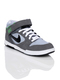

In [18]:
test_dataset[4]["messages"][1]["content"][1]["image"]

#### 2번 데이터 예측

In [19]:
after_train_results[2]

('{"gender": "Men", "masterCategory": "Footwear", "subCategory": "Sandal", "season": "Summer", "usage": "Casual", "baseColour": "Blue", "articleType": "Sandals"}',
 '{"gender": "Men", "masterCategory": "Footwear", "subCategory": "Sandal", "season": "Summer", "usage": "Casual", "baseColour": "Blue", "articleType": "Sandals"}')

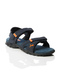

In [20]:
test_dataset[2]["messages"][1]["content"][1]["image"]

#### 3번 데이터 예측

In [21]:
after_train_results[3]

('{"gender": "Women", "masterCategory": "Footwear", "subCategory": "Shoes", "season": "Winter", "usage": "Casual", "baseColour": "Turquoise Blue", "articleType": "Flats"}',
 '{"gender": "Women", "masterCategory": "Footwear", "subCategory": "Shoes", "season": "Summer", "usage": "Casual", "baseColour": "Turquoise", "articleType": "Flats"}')

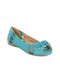

In [22]:
test_dataset[3]["messages"][1]["content"][1]["image"]

In [23]:
import json_repair
after_json_results = [(json_repair.repair_json(ans, return_objects=True), json_repair.repair_json(pred, return_objects=True)) for (ans, pred) in after_train_results]
after_answers = [ans for (ans, pred) in after_json_results]
after_predicts = [pred for (ans, pred) in after_json_results]

# 성능 확인 

In [24]:
# 전체 정확도를 계산하는 함수
def calculate_accuracy(y_true_list, y_pred_list):
    total_matched = 0
    total_fields = 0
    
    for dtrue, dpred in zip(y_true_list, y_pred_list):
        for key in dtrue.keys():
            total_fields += 1
            if key in dpred and dtrue[key] == dpred[key]:
                total_matched += 1
    
    return total_matched / total_fields if total_fields > 0 else 0

# 전체 정확도 출력
accuracy = calculate_accuracy(after_answers, after_predicts)
print(f"Overall Accuracy: {accuracy*100:.2f}%")


Overall Accuracy: 87.19%


In [25]:
def to_dict_if_str(obj):
    """
    obj가 str이면 JSON으로 로드하고,
    이미 dict 등의 타입이면 그대로 반환.
    """
    if isinstance(obj, str):
        try:
            return json.loads(obj)
        except json.JSONDecodeError:
            # json.loads()가 실패하면 json_repair로 한 번 더 시도
            return json_repair.repair_json(obj, return_objects=True)
    return obj

def compute_field_accuracy(predictions, targets, field):
    total = 0
    correct = 0
    
    for pred, target in zip(predictions, targets):
        # 문자열(JSON)인지 확인 후 dict로 변환
        pred_dict = to_dict_if_str(pred)
        target_dict = to_dict_if_str(target)
        
        if not isinstance(pred_dict, dict) or not isinstance(target_dict, dict):
            continue
        
        if field in pred_dict and field in target_dict:
            total += 1
            if pred_dict[field] == target_dict[field]:
                correct += 1
    
    return correct / total if total > 0 else 0


# 각 필드별 정확도 출력
for field in ['gender', 'masterCategory', 'subCategory', 'articleType', 'season', 'usage', 'baseColour']:
    field_acc = compute_field_accuracy(after_predicts, after_answers, field)
    print(f"{field} accuracy: {field_acc:.2%}")

gender accuracy: 98.42%
masterCategory accuracy: 99.10%
subCategory accuracy: 93.29%
articleType accuracy: 84.61%
season accuracy: 55.67%
usage accuracy: 90.71%
baseColour accuracy: 88.52%


### 2. 에러 분석을 위한 DataFrame 만들기

In [26]:
import pandas as pd

fields = ["gender", "masterCategory", "subCategory", 
          "season", "usage", "baseColour", "articleType"]

def make_error_analysis_df(answers, predicts):
    """
    answers: list of dict (정답)
    predicts: list of dict (예측)
    
    returns: pd.DataFrame
      - 각 row가 하나의 샘플
      - 각 column이 해당 field의 (정답, 예측, 정/오답 여부) 등
    """
    records = []
    for i, (ans, pred) in enumerate(zip(answers, predicts)):
        row_data = {"sample_id": i}  # 혹은 실제 파일 경로, productDisplayName 등 식별자
        for f in fields:
            true_val = ans.get(f, None)
            pred_val = pred.get(f, None)
            row_data[f+"_true"] = true_val
            row_data[f+"_pred"] = pred_val
            row_data[f+"_correct"] = (true_val == pred_val)
        records.append(row_data)
    return pd.DataFrame(records)

df_errors = make_error_analysis_df(after_answers, after_predicts)

# 예시 출력
df_errors.head(5)

,sample_id,gender_true,gender_pred,gender_correct,masterCategory_true,masterCategory_pred,masterCategory_correct,subCategory_true,subCategory_pred,subCategory_correct,...,season_correct,usage_true,usage_pred,usage_correct,baseColour_true,baseColour_pred,baseColour_correct,articleType_true,articleType_pred,articleType_correct
0,0,Women,Women,True,Accessories,Accessories,True,Jewellery,Jewellery,True,...,False,Casual,Casual,True,Black,Black,True,Necklace and Chains,Necklace,False
1,1,Women,Women,True,Apparel,Apparel,True,Loungewear and Nightwear,Innerwear,False,...,False,Casual,Casual,True,Blue,Blue,True,Nightdress,Nightdresses,False
2,2,Men,Men,True,Footwear,Footwear,True,Sandal,Sandal,True,...,True,Casual,Casual,True,Blue,Blue,True,Sandals,Sandals,True
3,3,Women,Women,True,Footwear,Footwear,True,Shoes,Shoes,True,...,False,Casual,Casual,True,Turquoise Blue,Turquoise,False,Flats,Flats,True
4,4,Men,Men,True,Footwear,Footwear,True,Shoes,Shoes,True,...,False,Casual,Casual,True,Grey,Grey,True,Sports Shoes,Casual Shoes,False


### 3. Field별 혼동행렬(Confusion Matrix) & Heatmap

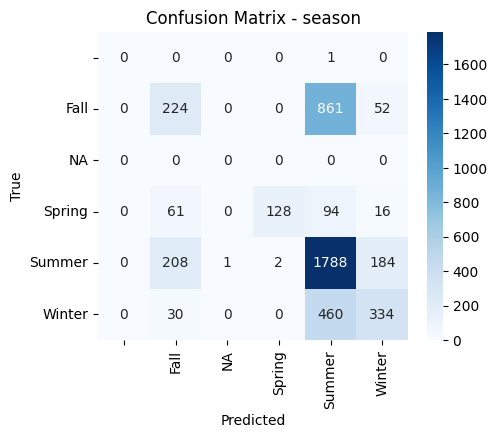

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix_for_field(df, field):
    # 실제값, 예측값
    y_true = df[f"{field}_true"]
    y_pred = df[f"{field}_pred"]
    
    # Label 목록 (전체에서 등장한 순서 / set 기반)
    labels = sorted(set(y_true.unique()).union(y_pred.unique()))
    
    # 혼동행렬 계산
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # 시각화
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {field}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

fields = ["gender", "season", "masterCategory", "subCategory", 
          "usage", "baseColour", "articleType"]

# 필드 혼동행렬
# plot_confusion_matrix_for_field(df_errors, "gender")
plot_confusion_matrix_for_field(df_errors, "season")
# plot_confusion_matrix_for_field(df_errors, "masterCategory")
# plot_confusion_matrix_for_field(df_errors, "subCategory")
# plot_confusion_matrix_for_field(df_errors, "usage")
# plot_confusion_matrix_for_field(df_errors, "baseColour")
# plot_confusion_matrix_for_field(df_errors, "articleType")


### 4. 어떤 클래스(값)에서 많이 틀리는지 통계

In [28]:
# season 필드에서만 정오답 여부 확인
df_season_wrong = df_errors[df_errors["season_correct"] == False].copy()

# 이 데이터프레임 안에서, 어떤 season(true)가 많은지
count_true = df_season_wrong["season_true"].value_counts()
print("틀린 데이터에서 실제 season 분포:")
print(count_true)

# 어떤 season(pred)가 많은지
count_pred = df_season_wrong["season_pred"].value_counts()
print("\n틀린 데이터에서 예측된 season 분포:")
print(count_pred)


틀린 데이터에서 실제 season 분포:
season_true
Fall      913
Winter    490
Summer    395
Spring    171
            1
Name: count, dtype: int64

틀린 데이터에서 예측된 season 분포:
season_pred
Summer    1416
Fall       299
Winter     252
Spring       2
NA           1
Name: count, dtype: int64


전처리 단계에서 유독 Summer가 많아서 모델이 Summer로 많이 예측하지 않을까 우려했었는데, 우려한대로 Summer로 다수 예측한 것을 볼 수 있습니다.  
그러나, 학습 초기 단계이기에 학습을 더 진행하면서 상황을 지켜보겠습니다. 